In [88]:
# TensorFlow and tf.keras
import tensorflow as tf

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
from scipy import stats,special
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm
import matplotlib.markers as mmarkers
from matplotlib.colors import SymLogNorm
import math
import time
import h5py

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

import innvestigate
import innvestigate.utils as iutils


import os
import pickle

1.13.1


In [89]:
# Show all numbers as float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

## Global parameters

In [90]:
# Transparency of Histograms
transp=0.6

In [91]:
# Set default options for paper
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white',
         'hatch.linewidth': 2.0}
plt.rcParams.update(params)
plt.style.context('default')

In [92]:
feature_names={'jetPt':r'$p_{T,jet}$',
               'jetEta':r'$\eta(jet)$',
               'jetPhi':r'$\phi(jet)$',
               'jetMass':r'$m_{jet}$',
               'jetMassSD':r'$m_{jet,sd}$',
               'tau1_b05':r'$\tau_{1}^{(0.5)}$',
               'tau2_b05':r'$\tau_{2}^{(0.5)}$',
               'tau3_b05':r'$\tau_{3}^{(0.5)}$',
               'tau1_sd_b05':r'$\tau_{1,sd}^{(0.5)}$',
               'tau2_sd_b05':r'$\tau_{2,sd}^{(0.5)}$',
               'tau3_sd_b05':r'$\tau_{3,sd}^{(0.5)}$',
               'tau1_b10':r'$\tau_{1}^{(1)}$',
               'tau2_b10':r'$\tau_{2}^{(1)}$',
               'tau3_b10':r'$\tau_{3}^{(1)}$',
               'tau1_sd_b10':r'$\tau_{1,sd}^{(1)}$',
               'tau2_sd_b10':r'$\tau_{2,sd}^{(1)}$',
               'tau3_sd_b10':r'$\tau_{3,sd}^{(1)}$',
               'tau1_b15':r'$\tau_{1}^{(1.5)}$',
               'tau2_b15':r'$\tau_{2}^{(1.5)}$',
               'tau3_b15':r'$\tau_{3}^{(1.5)}$',
               'tau1_sd_b15':r'$\tau_{1,sd}^{(1.5)}$',
               'tau2_sd_b15':r'$\tau_{2,sd}^{(1.5)}$',
               'tau3_sd_b15':r'$\tau_{3,sd}^{(1.5)}$',
               'tau1_b20':r'$\tau_{1}^{(2)}$',
               'tau2_b20':r'$\tau_{2}^{(2)}$',
               'tau3_b20':r'$\tau_{3}^{(2)}$',
               'tau1_sd_b20':r'$\tau_{1,sd}^{(2)}$',
               'tau2_sd_b20':r'$\tau_{2,sd}^{(2)}$',
               'tau3_sd_b20':r'$\tau_{3,sd}^{(2)}$',
               'chMult':r'$N_{ch}$',
               'neutMult':r'$N_{neut}$',
               'phoMult':r'$N_{\gamma}$',
               'eleMult':r'$N_{e}$',
               'muMult':r'$N_{\mu}$',
               'jetpull':r'$\phi_{pull}$',
               'beta3':r'$\beta_{3}$',
               'beta3_sd':r'$\beta_{3}^{g}$',
               'tau21':r'$\tau_{2}^{(1)} / \tau_{1}^{(1)}$',
               'deltaR_subjets':r'$\Delta_r$',
               'z':r'$z$',
               'dxy_max':r'$d_{xy,max}$',
               'dz_max':r'$d_{z,max}$'
              }

## Useful Functions

In [93]:
def build_XY(features, label, dic1, dic2):
    X = [np.concatenate((dic1[key], dic2[key])) for key in features]
    Y = [np.concatenate((dic1[key], dic2[key])) for key in label]
    dim = [ele.shape+(1,) for ele in X]
    for i in range(0,len(features)):
        X[i] = X[i].reshape(dim[i])
    return X,Y

In [94]:
def Get_LRP_Score(data,model,LRP_fct):
    
    # Strip model of softmax function for LRP
    model_ws = iutils.keras.graph.model_wo_softmax(model)
    
    # Build LRP analyzer
    lrp_analyzer = innvestigate.create_analyzer(LRP_fct, model_ws)
    lrp_score = [lrp_analyzer.analyze(ele) for ele in data]
    return lrp_score

In [95]:
def Confusion_Split(X,Y,pred,confidence_cut):
    ind_true_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,1] == 1))
    ind_true_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_positive = np.argwhere((pred[:,0,1] > confidence_cut) & (Y[0][:,0] == 1))
    ind_false_negative = np.argwhere((pred[:,0,0] > confidence_cut) & (Y[0][:,1] == 1))
    
    LRP_tp = X[ind_true_positive]
    LRP_tn = X[ind_true_negative]
    LRP_fp = X[ind_false_positive]
    LRP_fn = X[ind_false_negative]
    return LRP_tp, LRP_tn, LRP_fp, LRP_fn

In [96]:
def Draw_LRP_Image(LRP_tp, LRP_tn, LRP_fp, LRP_fn, LRP_fct):
    LRP_tp_mean = np.mean(LRP_tp, axis = 0).reshape(16,16)
    LRP_tn_mean = np.mean(LRP_tn, axis = 0).reshape(16,16)
    LRP_fp_mean = np.mean(LRP_fp, axis = 0).reshape(16,16)
    LRP_fn_mean = np.mean(LRP_fn, axis = 0).reshape(16,16)
    fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize = (10,10))
#    fig.suptitle('Images from ' + LRP_fct + ' algorithm')
    fig.tight_layout()
    im0 = ax[0][0].imshow(LRP_tp_mean,
                        interpolation = 'nearest',
                        origin = 'low',
                        norm = SymLogNorm(linthresh=0.001,base=10),
                        cmap = 'RdBu',
                        vmin = -10,
                        vmax = 10)
    ax[0][0].set_title('True Signal Images')
    cb0 = fig.colorbar(im0, shrink = 0.8, ax = ax[0][0])
    

    
    im1 = ax[1][1].imshow(LRP_tn_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          norm = SymLogNorm(linthresh = 0.001, base = 10),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[1][1].set_title('True Background Images')
    cb1 = fig.colorbar(im1,shrink=0.8, ax=ax[1][1])
    
    im2 = ax[0][1].imshow(LRP_fp_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          norm = SymLogNorm(linthresh = 0.001,base = 10),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[0][1].set_title('False Signal Images')
    fig.colorbar(im2, shrink = 0.8, ax = ax[0][1])
    
    im3 = ax[1][0].imshow(LRP_fn_mean,
                          interpolation = 'nearest',
                          origin = 'low',
                          norm = SymLogNorm(linthresh = 0.001,base = 10),
                          cmap = 'RdBu',
                          vmin = -10,
                          vmax = 10)
    ax[1][0].set_title('False Background Images')
    fig.colorbar(im3,shrink = 0.8, ax = ax[1][0])
    plt.savefig('plots/LRP/LRP_jetImages_imonly_' + LRP_fct + '.png')

In [97]:
def Make_LRP_Images(model,X,Y,LRP_fct,confidence_cut,standardize=True):
    pred = np.array([model.predict(ele) for ele in X])
    LRP_diff = Get_LRP_Score(X,
                             model,
                             LRP_fct)
    
    LRP_diff = np.array(LRP_diff).reshape(len(LRP_diff),grid,grid)
    
    LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_diff,
                                                     Y,
                                                     pred,
                                                     confidence_cut)
    if standardize:
        LRP_tp_std = np.array([stand(ele) for ele in LRP_tp])
        LRP_tn_std = np.array([stand(ele) for ele in LRP_tn])
        LRP_fp_std = np.array([stand(ele) for ele in LRP_fp])
        LRP_fn_std = np.array([stand(ele) for ele in LRP_fn])
    else:
        LRP_tp_std = LRP_tp
        LRP_tn_std = LRP_tn
        LRP_fp_std = LRP_fp
        LRP_fn_std = LRP_fn
    
    Draw_LRP_Image(LRP_tp_std,
                   LRP_tn_std,
                   LRP_fp_std,
                   LRP_fn_std,
                   LRP_fct)

In [98]:
def make_profile_data(x,values,bins):
    bin_mean, bin_edges, _ = stats.binned_statistic(x,
                                                    values,
                                                    statistic = 'mean',
                                                    bins = bins,
                                                    range = (0,1))
    bin_std, _, _ = stats.binned_statistic(x,
                                           values,
                                           statistic = 'std',
                                           bins = bins,
                                           range = (0,1))
    bin_count, _, _ = stats.binned_statistic(x,
                                             x,
                                             statistic = 'count',
                                             bins = bins,
                                             range = (0,1))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_mean, bin_std, bin_count, bin_edges, bin_centers, bin_width 

In [99]:
def stand(array):
    if np.std(array) == 0:
        return array - np.mean(array)
    else:
        return (array - np.mean(array))/np.std(array)

In [101]:
def Draw_Profile_small(X_test, Y_test, pred, LRP_norm, confidence_cut, feat, bins, histomax, relmin, relmax):
    ii = features.index(feat)
    ind_positive = np.argwhere((pred[:,0,1]>confidence_cut)).flatten()
    ind_negative = np.argwhere((pred[:,0,0]>confidence_cut)).flatten()
    LRP_p = np.array(LRP_norm)[ind_positive]
    LRP_n = np.array(LRP_norm)[ind_negative]
    X_p = [feat[ind_positive] for feat in X_test]
    X_n = [feat[ind_negative] for feat in X_test]
    bin_mean_p, bin_std_p, bin_count_p, bin_edges, bin_centers, bin_width = make_profile_data(X_p[ii].flatten(), LRP_p[:,ii], bins)
    bin_mean_n, bin_std_n, bin_count_n, _, _, _  = make_profile_data(X_n[ii].flatten(), LRP_n[:,ii], bins)
    
    bin_mean_p[bin_count_p < 50] = np.nan
    bin_std_p[bin_count_p < 50] = 0
    
    bin_mean_n[bin_count_n < 50] = np.nan
    bin_std_n[bin_count_n < 50] = 0

    fig = plt.figure(figsize=(6,7))
#    fig.suptitle('Histogram and relevance profile for ' + feature_names[ii])
    gs = gridspec.GridSpec(3, 1) 
    gs.update(wspace=0.025, hspace=0.1)
    
    ax0 = plt.subplot(gs[:2,:])
    ax0.hist(X_p[ii].flatten(),
                bins = bins,
                histtype = 'step',
#                normed=False,
                weights = np.ones(len(X_p[ii].flatten()))/len(X_p[ii].flatten()),
                fill = True,
                alpha = 0.55,
                label = "Signal",
                log = False,
#                density = True,
                range = [0,1],
                hatch='/',
                edgecolor='k'
                );
    ax0.hist(X_n[ii].flatten(),
                bins = bins,
                histtype = 'step',
#                normed=False,
                weights = np.ones(len(X_n[ii].flatten()))/len(X_n[ii].flatten()),
                fill = True,
                alpha = 0.55,
                label = 'Background',
                log = False,
#                density = True,
                range = [0,1],
                hatch = '\\',
                edgecolor='k'
                );
    l = ax0.legend();
#    ax0.grid()
    ax0.set_xlim(0,1)
    ax0.set_ylim(0,histomax)

    ax0.set_ylabel('Fraction')

    ax1 = plt.subplot(gs[2:,:])
    ax1.xaxis.set_ticks(np.arange(0, 1.2, 0.2))
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax1.plot(bin_centers,
             bin_mean_p,
             color = 'C0',
             label = "Signal")
    ax1.plot(bin_centers,
             bin_mean_n,
             color = 'C1',
             label = "Background")
    ax1.fill_between(bin_centers,
                     bin_mean_p - bin_std_p,
                     bin_mean_p + bin_std_p,
                     color = 'C0',
                     alpha = 0.2)
    ax1.fill_between(bin_centers,
                     bin_mean_n - bin_std_n,
                     bin_mean_n + bin_std_n,
                     color = 'C1',
                     alpha = 0.2)
    ax1.grid()
    ax1.set_ylim(relmin,relmax)
    ax1.set_xlim(0, 1)
    ax1.set_ylabel('Relevance')
    ax1.set_xlabel('Normalized ' + feature_names[feat])
    
    plt.savefig('plots/LRP/LRP_' + feat + '.png')

In [102]:
lrp_algorithms=['lrp', 'lrp.z', 'lrp.z_IB', 'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 'lrp.sequential_preset_b_flat']

## Import data:
Using ShowJetsData_full.npz to build the CNN.

In [103]:
grid = 16
test_sig = np.load('../data/ShowJets_test_ZZ.npz')
test_bkg = np.load('../data/ShowJets_test_QCD.npz')

In [104]:
n_test = len(test_sig['jetPt'])
print(n_test)

186430


In [105]:
removeFeat = ['jetconstPt_log',
 'jetconstEta_abs',
 'jetconstE_log',
 'jetconstPt_Jetlog',
 'charge',
 'isEle',
 'isPho',
 'isMuon',
 'isCh',
 'isNh',
 'delta_eta',
 'delta_phi',
 'deltaR_jet',
 'deltaR_subjet0',
 'deltaR_subjet1',
 'dxy',
 'dz',
 'jetpull',
 'labels']
feat_all = [key for key in train_sig.keys()];
for feat in removeFeat:
    feat_all.remove(feat)
# Swap jetImages into first place for automatized Model building
ind_image = feat_all.index('jetImages')
feat_all[0], feat_all[ind_image] = feat_all[ind_image], feat_all[0]

['jetImages',
 'jetPt',
 'jetEta',
 'jetPhi',
 'jetMass',
 'jetMassSD',
 'tau1_b05',
 'tau2_b05',
 'tau3_b05',
 'tau1_sd_b05',
 'tau2_sd_b05',
 'tau3_sd_b05',
 'tau1_b10',
 'tau2_b10',
 'tau3_b10',
 'tau1_sd_b10',
 'tau2_sd_b10',
 'tau3_sd_b10',
 'tau1_b20',
 'tau2_b20',
 'tau3_b20',
 'tau1_sd_b20',
 'tau2_sd_b20',
 'tau3_sd_b20',
 'chMult',
 'neutMult',
 'phoMult',
 'eleMult',
 'muMult',
 'jetpull',
 'beta3',
 'beta3_sd',
 'tau21']

# Model with just Images

## LRP

In [19]:
# Drop all events where the model predicted its result with less confidence then this
confidence_cut = 0.5

In [20]:
# Select features and build X_test and Y_test
features = ['jetImages']
label = ['labels']
X_test, Y_test = build_XY(features,label,test_sig, test_bkg)
Y_test = [Y_test[0][:,:2]]

# Reshape X_test for LRP
X_lrp = [[X_test[i][j] for i in range(len(features))] for j in range(n_test)]
for i in range(n_test):
    X_lrp[i][0] = X_lrp[i][0].reshape(1,grid,grid,1)
Y_lrp = Y_test

# Load Model
model = keras.models.load_model('model/CNN_Image.h1')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [22]:
pred = np.array([model.predict(ele) for ele in X_lrp])

### LRP.epsilon

In [25]:
LRP_fct = 'lrp.epsilon'
LRP_diff = Get_LRP_Score(X_lrp,
                         model,
                         LRP_fct)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [26]:
LRP_rediff = np.array([ele[0].reshape(grid,grid)/(np.max(np.abs(ele[0]))+0.000001) for ele in LRP_diff])

In [27]:
LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_rediff,
                                                 Y_lrp,
                                                 pred,
                                                 0.5)

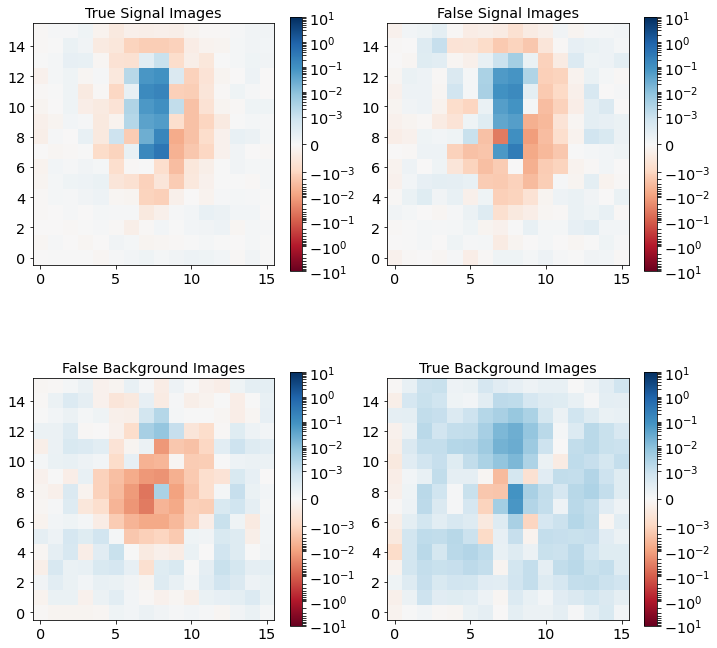

In [28]:
LRP_fct = 'lrp.epsilon'
Draw_LRP_Image(LRP_tp,
                   LRP_tn,
                   LRP_fp,
                   LRP_fn,
                   LRP_fct)

### LRP.preset_a

In [29]:
LRP_fct = 'lrp.sequential_preset_a'
LRP_diff = Get_LRP_Score(X_lrp,
                         model,
                         LRP_fct)

In [36]:
LRP_rediff = np.array([ele[0].reshape(grid,grid)/(np.max(np.abs(ele[0]))+0.000001) for ele in LRP_diff])

In [34]:
LRP_tp, LRP_tn, LRP_fp, LRP_fn = Confusion_Split(LRP_rediff,
                                                 Y_lrp,
                                                 pred,
                                                 0.5)

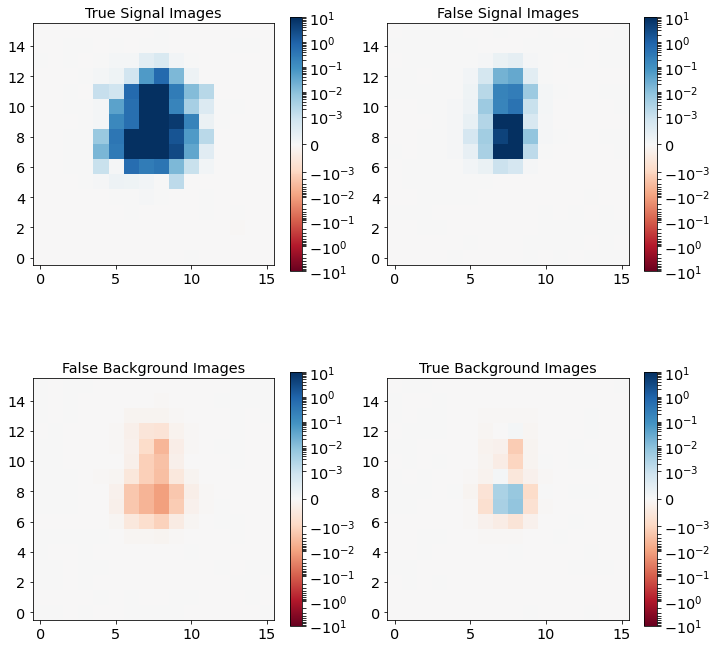

In [35]:
LRP_fct = 'lrp.sequential_preset_a'
Draw_LRP_Image(LRP_tp,
                   LRP_tn,
                   LRP_fp,
                   LRP_fn,
                   LRP_fct)

# Model with Image + All Expert Variables

## Compare different feature subsets

Model 0 Accuracy: 0.7438931502415017
Model 1 Accuracy: 0.8522340824948944
Model 2 Accuracy: 0.8541651021856828
Model 3 Accuracy: 0.8466019417494911
Model 4 Accuracy: 0.8692163278410339


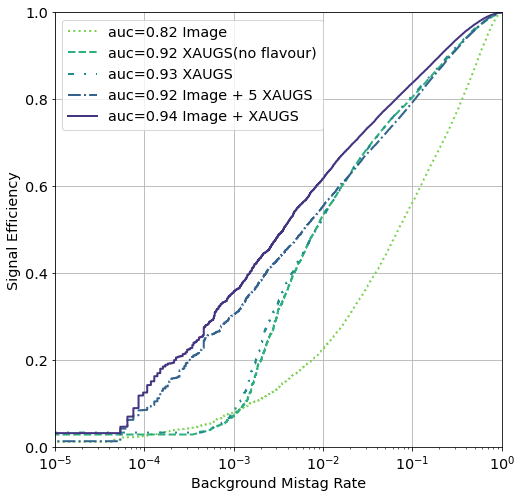

In [113]:
fpr=[]
tpr=[]
roc_auc=[]
acc = []
features = feat_all
label = ['labels']
for i in range(5):
    if i == 0:
        drop_those = []
        # features will be loaded into X
        features = ['jetImages']
        for feat in drop_those:
            features.remove(feat)
        best_model = keras.models.load_model('model/CNN_Image.h1')
    elif i == 1:
        drop_those = ['jetImages','chMult','neutMult','phoMult','eleMult','muMult']
        # features will be loaded into X
        features = feat_all[:]
        for feat in drop_those:
            features.remove(feat)
        best_model = keras.models.load_model('model/DNN_noflavour.h1')
    elif i == 2:
        drop_those = ['jetImages']
        # features will be loaded into X
        features = feat_all[:]
        for feat in drop_those:
            features.remove(feat)
        best_model = keras.models.load_model('model/DNN_all.h1')
    elif i == 3:
        drop_those = ['jetPt','jetEta','jetPhi',
     'tau1_b05','tau2_b05','tau3_b05','tau1_sd_b05','tau2_sd_b05','tau3_sd_b05','tau1_b10',
     'tau1_sd_b10','tau2_sd_b10','tau3_sd_b10','tau2_b20','tau3_b20','tau1_sd_b20','tau2_sd_b20',
    'tau3_sd_b20','chMult','neutMult','phoMult','eleMult','muMult','jetpull','beta3','beta3_sd','tau21']
        # features will be loaded into X
        features = feat_all[:]
        for feat in drop_those:
            features.remove(feat)
        best_model = keras.models.load_model('model/CNN_5XAUG.h1')
    elif i == 4:
        drop_those = []
        # features will be loaded into X
        features = feat_all[:]
        for feat in drop_those:
            features.remove(feat)
        best_model = keras.models.load_model('model/CNN_all.h1')
    
    X_test, Y_test = build_XY(features,label,test_sig, test_bkg)
    Y_test = [Y_test[0][:,:2]]
        
    acc_inb = best_model.evaluate(X_test, Y_test)
    predict = best_model.predict(X_test)

    # Build ROC curve
    fpr_inb, tpr_inb, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
    roc_auc_inb = auc(fpr_inb, tpr_inb)
    fpr.append(fpr_inb)
    tpr.append(tpr_inb)
    roc_auc.append(roc_auc_inb)
    acc.append(acc_inb[-1])

    
cmap_roc = matplotlib.cm.get_cmap('viridis')
color_roc = np.linspace(0.2,1,100)[::20]
ls = (0, (3, 5, 1, 5, 1, 5))
ls_roc = ['-.','-',':','--', ls]

fig = plt.figure(figsize=(8,8))
fig_grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.3)
sub_p = fig.add_subplot(fig_grid[0,0])
for i in range(len(acc)):
    if i == 0:
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.2f Image' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
    elif i == 1:
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.2f XAUGS(no flavour)' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
    elif i == 2:
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.2f XAUGS' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
    elif i == 3:
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.2f Image + 5 XAUGS' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
    elif i == 4:
        sub_p.plot(fpr[i], tpr[i], lw=2, label='auc=%.2f Image + XAUGS' % (roc_auc[i]), linestyle=ls_roc[i-3], color=cmap_roc(1-color_roc[i]))
#sub_p.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
sub_p.set_xlim([0.00001, 1.0])
sub_p.set_ylim([0, 1.0])
sub_p.grid()
sub_p.set_xscale("log")
sub_p.set_xlabel('Background Mistag Rate')
sub_p.set_ylabel('Signal Efficiency')
sub_p.legend(loc="upper left")
plt.savefig('plots/ROC/ROC_models.png')
for i in range(len(acc)):  
    print('Model ' + str(i) + ' Accuracy:', acc[i])

## LRP new

In [19]:
features = feat_all
label = ['labels']
X_test, Y_test = build_XY(features,label,test_sig, test_bkg)
Y_test = [Y_test[0][:,:2]]

# Load Model
full_model1 = keras.models.load_model('model/CNN_all.h1')
full_model2 = keras.models.load_model('model/CNN_all.h2')
full_model3 = keras.models.load_model('model/CNN_all.h3')
full_model4 = keras.models.load_model('model/CNN_all.h4')

# Reshape Data, for easier application of LRP algorithm
X_lrp = [ [ X_test[i][j] for i in range(len(features)) ] for j in range(n_test) ]
for i in range(n_test):
    X_lrp[i][0] = X_lrp[i][0].reshape(1, grid, grid, 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [20]:
# Get LRP score
LRP_full1 = Get_LRP_Score(X_lrp, full_model1, "lrp.epsilon")
LRP_sum1 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full1])
LRP_norm1 = np.array([ ele / np.max(np.abs(ele)) for ele in LRP_sum1])
# Get Full prediction for Confusion matrix split

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [21]:
# Get LRP score
LRP_full2 = Get_LRP_Score(X_lrp, full_model2, "lrp.epsilon")
LRP_sum2 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full2])
LRP_norm2 = np.array([ ele / np.max(np.abs(ele)) for ele in LRP_sum2])

In [22]:
# Get LRP score
LRP_full3 = Get_LRP_Score(X_lrp, full_model3, "lrp.epsilon")
LRP_sum3 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full3])
LRP_norm3 = np.array([ ele / np.max(np.abs(ele)) for ele in LRP_sum3])

In [29]:
# Get LRP score
LRP_full4 = Get_LRP_Score(X_lrp, full_model4, "lrp.epsilon")
LRP_sum4 = np.array([[np.sum(feature) for feature in ele] for ele in LRP_full4])
LRP_norm4 = np.array([ ele / (np.max(np.abs(ele)) + 0.000001 ) for ele in LRP_sum4])

In [30]:
pred_full1 = np.array([full_model1.predict(X_lrp[i]) for i in range(n_test)])
pred_full2 = np.array([full_model2.predict(X_lrp[i]) for i in range(n_test)])
pred_full3 = np.array([full_model3.predict(X_lrp[i]) for i in range(n_test)])
pred_full4 = np.array([full_model4.predict(X_lrp[i]) for i in range(n_test)])

In [31]:
LRP_mean1 = np.array([np.mean(np.abs(LRP_norm1),axis=0)])
LRP_mean2 = np.array([np.mean(np.abs(LRP_norm2),axis=0)])
LRP_mean3 = np.array([np.mean(np.abs(LRP_norm3),axis=0)])
LRP_mean4 = np.array([np.mean(np.abs(LRP_norm4),axis=0)])

In [32]:
LRP_mean = np.mean(np.concatenate((LRP_mean1, LRP_mean2, LRP_mean3, LRP_mean4)), axis = 0)
LRP_std = np.std(np.concatenate((LRP_mean1, LRP_mean2, LRP_mean3, LRP_mean4)), axis = 0)

In [33]:
LRP_norm_all = (LRP_norm1 + LRP_norm2 + LRP_norm3 + LRP_norm4) / 4
pred_all = (pred_full1 + pred_full2 + pred_full3 + pred_full4) / 4

## Rank Features by average of absolute relevance

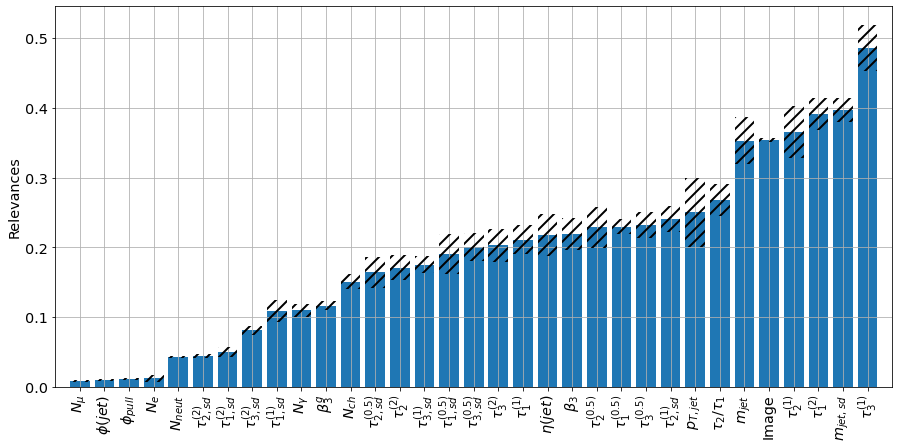

In [48]:
LRP_order = [features[i] for i in np.argsort(LRP_mean)]
LRP_std_sorted = [LRP_std[i] for i in np.argsort(LRP_mean)]
LRP_order2 = [feature_names[feat] for feat in LRP_order]
relevances = np.sort(LRP_mean)
plt.figure(figsize=(15,7))
plt.xlim([-1,33])
#plt.ylim([0,0.5])
barplot = plt.bar(LRP_order2, relevances)
count = 0
for b in barplot:    
    plt.fill_between([b.get_x(), b.get_x() + b.get_width()],
                     b.get_height() - LRP_std_sorted[count],
                     b.get_height() + LRP_std_sorted[count],
                     lw=0,
                     fc='none',
                     ec='k',
                     hatch='//',
                     zorder=2)    
    count += 1
#plt.fill_between(,relevances + LRP_std,relevances - LRP_std)
plt.xticks(rotation= 'vertical');
plt.grid()
plt.ylabel('Relevances')
plt.savefig('plots/LRP/LRP_barplot.png')

### Histogram of LRP scores for features

In [50]:
# plt.figure(figsize=(32,18))
#subset = {0,1,2,10,11,12,22,28,29,30}
subset = list(range(len(features)))
# for i in range(1, len(LRP_sum[0])):
#     if i in subset:
#         plt.hist(np.abs(LRP_norm[:,i]),
#                  bins = 30,
#                  density = True,
# #                 weights = np.ones(len(LRP_norm[:,i].flatten()))/len(LRP_norm[:,i].flatten()),
#                  range = [0,2],
#                  label = feature_names[i-1],
#                  histtype = 'step',
#                  log = False);
# plt.legend()
# plt.xlabel('Relevance')
# plt.ylim(0,16)
# plt.xlim(0,1.2)
# plt.grid(alpha=0.5)
# plt.ylabel('Density')
# plt.title('Histogram of Relevances')
# plt.savefig('plots/LRP_histogram.png')

In [51]:
selection = LRP_order[-11:]
subset = [features.index(feat) for feat in selection]
# valid_markers = [key[0] for key in mmarkers.MarkerStyle.markers.items()]
# markers = valid_markers
# colors = ['C'+str(i) for i in range(len(subset))]
# plt.figure(figsize=(12,7))
# for i in range(1, len(LRP_sum[0])):
#     if i in subset:
#         n,bins,patches=plt.hist(np.abs(LRP_norm[:,i]),
#                  bins = 30,
#                  range = [0,1],
#                  weights = np.ones(len(LRP_norm[:,i].flatten()))/len(LRP_norm[:,i].flatten()),               
#                  histtype = 'step',
#                  color = colors[subset.index(i)],
#                  log = False,
#                  density = True);
#         plt.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]),
#                     n,
#                     marker=markers[subset.index(i)],
#                     color = colors[subset.index(i)],
#                     label = feature_names[i],
#                     alpha=1)
# plt.legend()
# plt.xlabel('Relevance')
# plt.ylim(0,9)
# plt.xlim(0,1)
# plt.grid(alpha=0.5)
# plt.ylabel('Fraction')
# plt.title('Histogram of Relevances')
# plt.savefig('plots/LRP_histogram.png')

### Relevance profiles small

In [ ]:
# PROMOTE MYBIN AND MAXDEN INTO DICTIONARY FOR EASIER USE !!

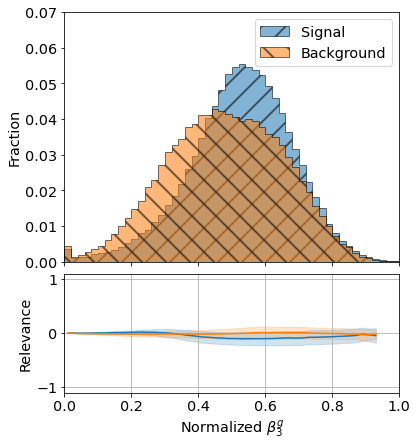

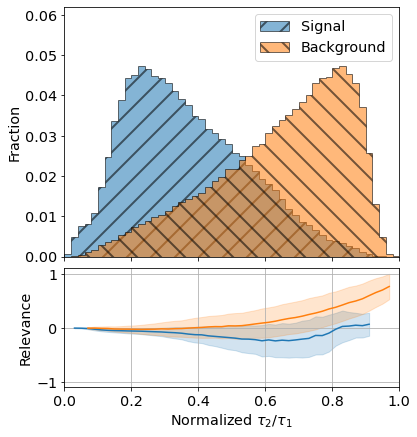

In [74]:
#profile_selection = selection[:]
profile_selection = feat_all[:]
profile_selection.remove('jetImages')
confidence_cut = 0.5
mybin = [50, 50, 50, 50, 50,
         50, 50, 50, 50, 50,
         50, 50, 50, 50, 50,
         50, 50, 50, 50, 50,
         50, 50, 50, 10, 8,
         15, 3, 2, 50, 50,
         50, 50]
maxden = [0.06, 0.06, 0.03, 0.3, 0.4,
          0.06, 0.06, 0.06, 0.08, 0.06,
          0.06, 0.09, 0.08, 0.08, 0.33,
          0.25, 0.25, 0.14, 0.14, 0.11,
          0.62, 0.62, 0.6, 0.3, 0.3,
          0.2, 1, 1, 0.04, 0.08,
          0.07, 0.062]
for i in range(30, 32):
    Draw_Profile_small(X_test,
                 Y_test,
                 pred_all,
                 LRP_norm_all,
                 confidence_cut,
                 profile_selection[i],
                 mybin[i],
                 maxden[i],
                 -1.1,
                 1.1)

## Scatter plots

In [79]:
selection_noimage = selection[:]
selection_noimage.remove('jetImages')

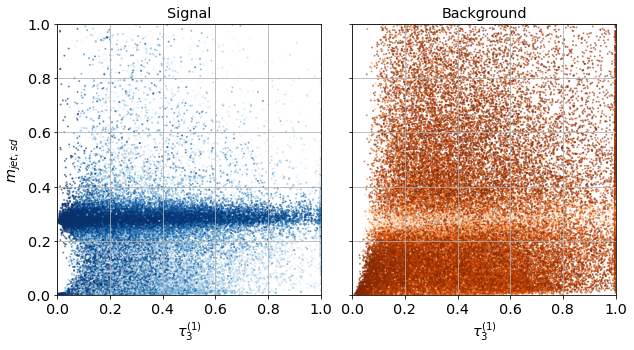

In [80]:
feat1 = selection_noimage[-1]
feat2 = selection_noimage[-2]
i1 = feat_all.index(feat1)
i2 = feat_all.index(feat2)
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2) 
gs.update(wspace=0.12, hspace=0.0025)

ax0 = plt.subplot(gs[0])
# ax0.scatter(data_test[feat1][data_test['labels'][:,0]==1].flatten(),
#             data_test[feat2][data_test['labels'][:,0]==1].flatten(),
#             c = pred_full[:,:,0][data_test['labels'][:,0]==1].flatten(),
#             cmap = 'Blues',
#             alpha = 0.5,
#             s = 1
#            )
ax0.scatter(data_test[feat1][data_test['labels'][:,1]==1].flatten(),
            data_test[feat2][data_test['labels'][:,1]==1].flatten(),
            c = pred_all[:,:,1][data_test['labels'][:,1]==1].flatten(),
            cmap = 'Blues',
            alpha = 0.5,
            s = 1
           )
ax0.set_xlabel(feature_names[feat1])
ax0.set_ylabel(feature_names[feat2])
ax0.set_title('Signal')
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.grid()

ax1 = plt.subplot(gs[1])

# ax1.scatter(data_test[feat1][data_test['labels'][:,1]==1].flatten(),
#             data_test[feat2][data_test['labels'][:,1]==1].flatten(),
#             c = pred_full[:,:,0][data_test['labels'][:,1]==1].flatten(),
#             cmap = 'Oranges',
#             alpha = 0.5,
#             s = 1
#            )
ax1.scatter(data_test[feat1][data_test['labels'][:,0]==1].flatten(),
            data_test[feat2][data_test['labels'][:,0]==1].flatten(),
            c = pred_all[:,:,0][data_test['labels'][:,0]==1].flatten(),
            cmap = 'Oranges',
            alpha = 0.5,
            s = 1
           )

ax1.set_xlabel(feature_names[feat1])
#ax1.set_ylabel(feature_names[i2])
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Background')
ax1.grid()
ax1.set_yticklabels([])

plt.show()

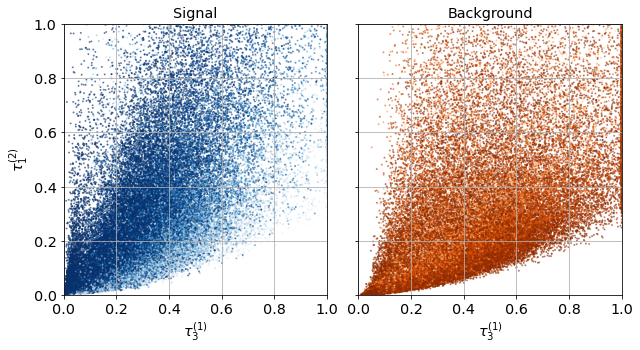

In [82]:
feat1 = selection_noimage[-1]
feat2 = selection_noimage[-3]
i1 = feat_all.index(feat1)
i2 = feat_all.index(feat2)
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2) 
gs.update(wspace=0.12, hspace=0.0025)

ax0 = plt.subplot(gs[0])
ax0.scatter(data_test[feat1][data_test['labels'][:,1]==1].flatten(),
            data_test[feat2][data_test['labels'][:,1]==1].flatten(),
            c = pred_all[:,:,1][data_test['labels'][:,1]==1].flatten(),
            cmap = 'Blues',
            alpha = 0.5,
            s = 1
           )
ax0.set_xlabel(feature_names[feat1])
ax0.set_ylabel(feature_names[feat2])
ax0.set_title('Signal')
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.grid()

ax1 = plt.subplot(gs[1])

ax1.scatter(data_test[feat1][data_test['labels'][:,0]==1].flatten(),
            data_test[feat2][data_test['labels'][:,0]==1].flatten(),
            c = pred_all[:,:,0][data_test['labels'][:,0]==1].flatten(),
            cmap = 'Oranges',
            alpha = 0.5,
            s = 1
           )

ax1.set_xlabel(feature_names[feat1])
#ax1.set_ylabel(feature_names[i2])
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Background')
ax1.grid()
ax1.set_yticklabels([])

plt.show()

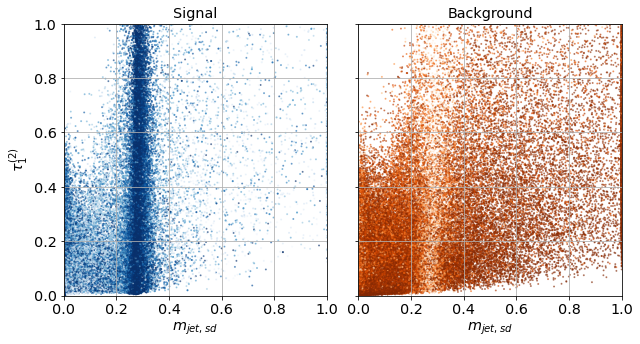

In [83]:
feat1 = selection_noimage[-2]
feat2 = selection_noimage[-3]
i1 = feat_all.index(feat1)
i2 = feat_all.index(feat2)
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2) 
gs.update(wspace=0.12, hspace=0.0025)

ax0 = plt.subplot(gs[0])
ax0.scatter(data_test[feat1][data_test['labels'][:,1]==1].flatten(),
            data_test[feat2][data_test['labels'][:,1]==1].flatten(),
            c = pred_all[:,:,1][data_test['labels'][:,1]==1].flatten(),
            cmap = 'Blues',
            alpha = 0.5,
            s = 1
           )
ax0.set_xlabel(feature_names[feat1])
ax0.set_ylabel(feature_names[feat2])
ax0.set_title('Signal')
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.grid()

ax1 = plt.subplot(gs[1])

ax1.scatter(data_test[feat1][data_test['labels'][:,0]==1].flatten(),
            data_test[feat2][data_test['labels'][:,0]==1].flatten(),
            c = pred_all[:,:,0][data_test['labels'][:,0]==1].flatten(),
            cmap = 'Oranges',
            alpha = 0.5,
            s = 1
           )

ax1.set_xlabel(feature_names[feat1])
#ax1.set_ylabel(feature_names[i2])
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_title('Background')
ax1.grid()
ax1.set_yticklabels([])

plt.show()